# CS Training

**Goal:** Look at how the cosine similarity between the slots _evolves_ during training.

**Motivation:** When I reran the `Cosine-similarity` notebook between trainings, I got really different results, so I'm curious to zone in on this a bit.

In [1]:
import torch
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib as mlp

import json, yaml, os
os.sys.path.append('code')

from plotting import plot_kslots, plot_kslots_iters
from data import make_batch
from model import SlotAttentionPosEmbed

# Set numpy seed for test set sampling 
np.random.seed(24082023)

%load_ext autoreload
%autoreload 2

In [2]:
device = 'cpu'

In [3]:
cID_prev = 'learn-init-warm2'
with open(f'code/configs/{cID_prev}.yaml') as f:
    cd = yaml.safe_load(f)

hps = cd['hps']
hps['device'] = device

m = SlotAttentionPosEmbed(**hps)

In [4]:
from train import hungarian_matching
import torch.nn.functional as F

k_slots=3
max_n_rings=2
resolution=(32,32)

In [5]:
def get_loss(m,X,mask):

    with torch.no_grad():

        queries, att, wts = m(X)

    flat_mask = mask.reshape(-1,max_n_rings, np.prod(resolution))

    att_ext  = torch.tile(att.unsqueeze(2), dims=(1,1,max_n_rings,1)) 
    mask_ext = torch.tile(flat_mask.unsqueeze(1),dims=(1,k_slots,1,1)) 

    pairwise_cost = F.binary_cross_entropy(att_ext,mask_ext,reduction='none').mean(axis=-1)

    indices = hungarian_matching(pairwise_cost)

    # Apply the sorting to the predict
    bis=torch.arange(bs).to(device)
    indices=indices.to(device)

    slots_sorted = torch.cat([att[bis,indices[:,0,ri]].unsqueeze(1) for ri in range(max_n_rings)],dim=1)

    rings_sorted = torch.cat([flat_mask[bis,indices[:,1,ri]].unsqueeze(1) for ri in range(max_n_rings)],dim=1)

    # Calculate the loss
    # avg the pixel loss, but don't avg over the exs
    loss = F.binary_cross_entropy(slots_sorted,rings_sorted,reduction='none').sum(axis=1).mean(axis=-1)

    # And cosine sim b/w chosen centroids
    mus = torch.cat([queries[bis,indices[:,0,ri]].unsqueeze(1) for ri in range(max_n_rings)],dim=1)
    cs = torch.nn.CosineSimilarity()(mus[:,0],mus[:,1])

    return loss, cs

In [6]:
bs = 100
kwargs = cd['data']
X,y, mask = make_batch(N_events=bs, **kwargs)

/gpfs/slac/atlas/fs1/d/nhartman/Slot Attention/code/data.py:94: RuntimeWarning: invalid value encountered in true_divide
  eventMasks = np.where(eventHistograms>0,eventMasks/eventHistograms,eventMasks)


In [8]:
from tqdm import tqdm

losses = []
cs = []

for i in tqdm(range(0,1000_000,1_000)):
    weightPath = f'code/models/{cID_prev}/m_{i}.pt'
    m.load_state_dict(torch.load(weightPath,map_location=device))
    
    loss, cs_centroids = get_loss(m,X,mask)
    
    losses.append(loss.mean())
    cs.append(cs_centroids.mean())

100%|██████████| 1000/1000 [08:08<00:00,  2.05it/s]


In [28]:
i

262000

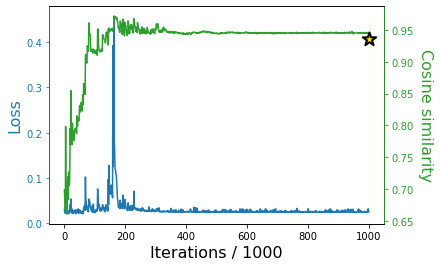

In [18]:
c1 = 'C0'
c2 = 'C2'

plt.plot(losses,color=c1,label='BCE loss')

ax1 = plt.gca()
ax2 = ax1.twinx()

ax2.plot(cs,color=c2,label='Cosine sim b/w centroids')
ax2.tick_params(axis='y', colors=c2) 
ax2.spines['right'].set_color(c2)

ax1.tick_params(axis='y', colors=c1) 
ax2.spines['left'].set_color(c1)


ax2.scatter(len(cs)-1,[0.9357],200,marker="*",color='gold',ec='k',zorder=10,lw=2)


ax1.set_xlabel('Iterations / 1000',fontsize=16)
ax1.set_ylabel('Loss',color=c1,fontsize=16)
ax2.set_ylabel('Cosine similarity',color=c2,rotation=270,labelpad=20,
               fontsize=16)
# plt.legend()
# plt.title('H=16,Q=64, learn init with warm start',loc='right')
plt.show()

In [10]:
cs_centroids

tensor([0.9420, 0.9441, 0.9449, 0.9453, 0.9469, 0.9441, 0.9442, 0.9435, 0.9487,
        0.9441, 0.9450, 0.9456, 0.9428, 0.9453, 0.9440, 0.9437, 0.9429, 0.9459,
        0.9443, 0.9454, 0.9437, 0.9460, 0.9444, 0.9485, 0.9434, 0.9447, 0.9488,
        0.9469, 0.9443, 0.9442, 0.9445, 0.9421, 0.9998, 0.9487, 0.9439, 0.9442,
        0.9450, 0.9439, 0.9432, 0.9432, 0.9448, 0.9444, 0.9538, 0.9434, 0.9441,
        0.9433, 0.9433, 0.9451, 0.9489, 0.9455, 0.9450, 0.9452, 0.9446, 0.9447,
        0.9464, 0.9451, 0.9449, 0.9444, 0.9511, 0.9443, 0.9421, 0.8945, 0.9432,
        0.9454, 0.9453, 0.9460, 0.9444, 0.9445, 0.9443, 0.9429, 0.9448, 0.9441,
        0.9434, 0.9447, 0.9443, 0.9437, 0.9431, 0.9434, 0.9460, 0.9427, 0.9442,
        0.9437, 0.9459, 0.9443, 0.9441, 0.9468, 0.9447, 0.9462, 0.9479, 0.9466,
        0.9450, 0.9464, 0.9447, 0.9452, 0.9469, 0.9434, 0.9464, 0.9421, 0.9476,
        0.9443])